In [2]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.layers import Dense, Input, Concatenate, Masking, Dropout, BatchNormalization

from tensorflow.keras import regularizers 
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model



from tensorflow.keras.metrics import TopKCategoricalAccuracy

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

import sys 
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from joblib import load
import seaborn as sns

import matplotlib.pyplot as plt


2025-04-29 03:49:25.548043: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 03:49:25.548610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 03:49:25.551807: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 03:49:25.559654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745894965.572537 2823532 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745894965.57

In [4]:
lstmDropout = [0.16, 0.24, 0.32]
lstmRDropout = [0.1, 0.1, 0.15]
lstmL2 = [0.002, 0.0025, 0.003]

denseDropout = [0.3, 0.3]
denseL2 = [0.002, 0.001]


all_labels = ['LAST', 'TOMORROW', 'HORSE', 'THINK', 'IN', 'SLEEP', 'IMPORTANT', 'DIFFERENT', 'GOOD', 'SLOW', 'GRASS', 'FAST', 'FATHER', 'EMAIL', 'WEATHER', 'KITCHEN', 'SOME',
'INTERNET', 'GETTOGETHER', 'KNOW', 'NO', 'CAKE', 'OUT', 'WHY', 'TEXT', 'PLAY', 'WINTER', 'STREET', 'GAME', 'VEGETABLE', 'TRAIN', 'STOP', 'SPRING', 'EARTH', 'AFTER',
'SMALL', 'HAPPY', 'CAR', 'ANGRY', 'FIRE', 'NONE', 'ORANGE', 'SORRY', 'YESTERDAY', 'PARK', 'COME', 'COFFEE', 'LESS', 'MONTH', 'EASY', 'HOT', 'MOON', 'MOTHER', 'SIT',
'BASEBALL', 'NEXT', 'YEAR', 'WORK', 'METAL', 'TENNIS', 'BATHROOM', 'MORNING', 'LATER', 'TEA', 'FAMILY', 'RAIN', 'SELL', 'PICTURE', 'GO', 'CAMERA', 'BIRD', 'COUNTRY', 'DOOR', 'FOOTBALL',
'BOOK', 'NAME', 'SAD', 'TEACHER', 'HELLO', 'BEACH', 'WINDOW', 'LEARN', 'SUMMER', 'CLOSE', 'FRUIT',
'MORE', 'WHITE', 'APPLE', 'MANY', 'TRUE', 'UP', 'FRIEND', 'PLEASE', 'BROWN', 'FLOWER', 'GIRL', 'SILVER', 'SING', 'BIG', 'SISTER', 'HOME', 'CHAIR', 'SPORTS', 'COLOR',
'RESTAURANT', 'STAR', 'READ', 'UNDERSTAND', 'WATCH', 'MAYBE', 'DANCE', 'BUS', 'YELLOW', 'SEE', 'SCHOOL', 'STUDENT', 'RED', 'ANIMAL', 'PHONE', 'GREEN', 'SUN', 
'FIRST', 'WIND', 'COOK', 'BLUE', 'LOVE', 'YES', 'COLD', 'HELP', 'WATER', 'COOKIE', 'NEED', 'START', 'SHOES', 'BAD', 'OPEN', 'HOUSE', 'BOY', 'FISH', 'BEDROOM', 'NOW', 'TABLE', 'PEN', 'TREE', 'LONG', 'BEFORE',
'LISTEN', 'DAY', 'GOLD', 'NEW', 'WOOD', 'TIME', 'BROTHER', 'DOWN', 'ALL', 'BUY', 'OFFICE', 'WEEK', 'OLD', 'WRITE', 'FINISH', 'BIRTHDAY', 'COMPUTER', 'ICE']

#replace before with church

leftIn = Input(shape=(None, 63), name = "LeftHand")
rightIn = Input(shape=(None, 63), name = "RightHand")

leftMask = Masking(mask_value=0.)(leftIn)
rightMask = Masking(mask_value=0.)(rightIn)

left1LSTM = LSTM(128, return_sequences=True, name="firstLeftLstm",
                  dropout = lstmDropout[0], recurrent_dropout = lstmRDropout[0],
                  kernel_regularizer=regularizers.l2(lstmL2[0])
                  )(leftMask)
right1LSTM = LSTM(128, return_sequences=True, name="firstRightLstm",
                   dropout = lstmDropout[0], recurrent_dropout = lstmRDropout[0],
                   kernel_regularizer=regularizers.l2(lstmL2[0])
                   )(rightMask)

left1LSTM = BatchNormalization()(left1LSTM)
right1LSTM = BatchNormalization()(right1LSTM)

left2LSTM = LSTM(128, return_sequences=True, name="secondLeftLstm",
                  dropout = lstmDropout[1], recurrent_dropout = lstmRDropout[1],
                  kernel_regularizer=regularizers.l2(lstmL2[1])
                  )(left1LSTM)
right2LSTM = LSTM(128, return_sequences=True, name="secondRightLstm",
                   dropout = lstmDropout[1], recurrent_dropout = lstmRDropout[1],
                   kernel_regularizer=regularizers.l2(lstmL2[1])
                   )(right1LSTM)

left2LSTM = BatchNormalization()(left2LSTM)
right2LSTM = BatchNormalization()(right2LSTM)

left3LSTM = LSTM(384, return_sequences=False, name="finalLeftLstm",
                  dropout = lstmDropout[2], recurrent_dropout = lstmRDropout[2],
                  kernel_regularizer=regularizers.l2(lstmL2[2])
                  )(left2LSTM)
right3LSTM = LSTM(384, return_sequences=False, name="finalRightLstm",
                  dropout = lstmDropout[2], recurrent_dropout = lstmRDropout[2],
                  kernel_regularizer=regularizers.l2(lstmL2[2])
                  )(right2LSTM)

combine = Concatenate(name="combined")([left3LSTM, right3LSTM])
X = Dense(384, activation='relu', kernel_regularizer = regularizers.l2(denseL2[0]))(combine)
X = Dropout(denseDropout[0])(X)
Y = Dense(256, activation='relu')(X)
Y = Dropout(denseDropout[1])(Y)
output = Dense(164, activation='softmax', kernel_regularizer = regularizers.l2(denseL2[1]))(Y)

lossF = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model = Model(inputs=[leftIn, rightIn], outputs=output)
model.compile(optimizer='adam',
                      loss=lossF,
                        metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])
#model.summary()


#model.load_weights('VLossChurch1p05.h5')

#model.load_weights("Models/LastSize/Best384_LSTM.h5")
#model.load_weights("Models/LastSize/PotentialBest164.h5")  #1.081 vall loss

#model.load_weights("Val106_164.h5")  #1.065 vall loss

#model.load_weights("Models/LastSize/LastDays.h5")  
model.load_weights("RecentFinalArchitecture.h5")  




2025-04-29 03:49:28.856104: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
nclasses = 164
def wristNormalise(landmarks):
    wrist = landmarks[0]
    for lm in landmarks:
        lm[0] -= wrist[0]
        lm[1] -= wrist[1]
        lm[2] -= wrist[2]
    return landmarks

def format_data(data):
    num_frames =len(data)
    formatted = np.zeros((num_frames, 2, 21, 3))
    for i, frame in enumerate(data):
        for j in frame:
            side = 0 if j['side'] == 'Left' else 1
            landmarks = j['landmarks']
            formatted[i, side] = landmarks
    return formatted

def Preprocess_Batch(batch_sequence):
    max_frames = max(len(sequence) for sequence in batch_sequence)
    batchSize = len(batch_sequence)
    padded = np.zeros((batchSize, max_frames, 63))

    for i, sequence in enumerate(batch_sequence):
        sequence = wristNormalise(sequence)
        reshaped = sequence.reshape(len(sequence), -1) #flattening the 21x3
        padded[i, :len(sequence)] = reshaped # ignores the paddes frames; copies the actual recorded data within the 'new' frame
    return padded

#function to pass variable length batches to the model
def Batch_Passer(leftHand, rightHand, labels, batchSize=32):
    indexes = np.arange(len(leftHand))

    while True:
        batchDexes = np.random.choice(indexes, size=batchSize, replace=False)
        lhBatch = [leftHand[i] for i in batchDexes]
        rhBatch = [rightHand[i] for i in batchDexes]
        labelBatch = [labels[i] for i in batchDexes]

        leftPad = Preprocess_Batch(lhBatch)
        rightPad = Preprocess_Batch(rhBatch)

        labelBatch = to_categorical(labelBatch, num_classes=nclasses)

        yield [leftPad, rightPad], labelBatch
def TestBatchGenerator(leftHand, rightHand, labels, batchSize=32):
    total = len(leftHand)

    for start in range(0, total, batchSize):
        end_idx = min(start + batchSize, total)
        
        lhBatch = [leftHand[i] for i in range(start, end_idx)]
        rhBatch = [rightHand[i] for i in range(start, end_idx)]
        labelBatch = [labels[i] for i in range(start, end_idx)]
        
        leftPad = Preprocess_Batch(lhBatch)
        rightPad = Preprocess_Batch(rhBatch)
        labelBatch = to_categorical(labelBatch, num_classes=nclasses)
        
        yield [leftPad, rightPad], labelBatch



test = pd.read_csv("testss_164.csv")

#testwithbefore = pd.read_csv("testss_clean.csv")

#befores = testwithbefore[testwithbefore["Before"]] 


# Load test data
testLeft = []
testRight = []
testLabels = []
for idx, row in test.iterrows():
    file = f"164LabelLandmarks/{row['Video file'].replace('.mp4', '.joblib')}"
    try:
       tdata = load(file)
    except Exception as e:
        print(f"Error loading {file}: {e}", file=sys.stderr)
        continue
    tdata = format_data(tdata)

    left = tdata[:,0,:,:] #left hand
    right = tdata[:,1,:,:] #right hand

    testLabels.append(row["Gloss"])
    testLeft.append(left)
    testRight.append(right)
def evaluate_in_batches(model, leftHand, rightHand, labels, batch_size=32):
    """Evaluate model using batches without generator"""
    total_loss = 0
    total_acc = 0
    num_batches = 0
    
    for start in range(0, len(leftHand), batch_size):
        end = min(start + batch_size, len(leftHand))
        
        # Prepare batch
        lhBatch = [leftHand[i] for i in range(start, end)]
        rhBatch = [rightHand[i] for i in range(start, end)]
        labelBatch = [labels[i] for i in range(start, end)]
        
        # Preprocess
        leftPad = Preprocess_Batch(lhBatch)
        rightPad = Preprocess_Batch(rhBatch)
        labelBatch = to_categorical(labelBatch, num_classes=nclasses)
        
        # Evaluate batch
        metrics = model.test_on_batch(
            [leftPad, rightPad],
            labelBatch
        )
        total_loss += metrics[0]
        total_acc += metrics[1]
        num_batches += 1
    
    return total_loss/num_batches, total_acc/num_batches

Error loading 164LabelLandmarks/532633297898772-BEDROOM.joblib: [Errno 2] No such file or directory: '164LabelLandmarks/532633297898772-BEDROOM.joblib'


In [6]:
def analyse_predictions(model, leftHand, rightHand, labels, batch_size=32, class_names=all_labels):
    correct_confidences = []
    incorrect_confidences = []

    for start in range(0, len(leftHand), batch_size):
        end = min(start + batch_size, len(leftHand))

        lhBatch = [leftHand[i] for i in range(start, end)]
        rhBatch = [rightHand[i] for i in range(start, end)]
        labelBatch = [labels[i] for i in range(start, end)]

        leftPad = Preprocess_Batch(lhBatch)
        rightPad = Preprocess_Batch(rhBatch)

        predictions = model.predict([leftPad, rightPad])
        predicted_labels = np.argmax(predictions, axis=1)

        for idx, true_label in enumerate(labelBatch):
            #print(true_label)
            true_label_idx = class_names.index(true_label)
            predicted_label = predicted_labels[idx]
            true_confidence = predictions[idx, true_label_idx]
            predicted_confidence = predictions[idx, predicted_label]

            if predicted_label == true_label_idx:
                correct_confidences.append(true_confidence)
            else:
                incorrect_confidences.append({
                    'true_label': true_label_idx,
                    'true_confidence': true_confidence,
                    'predicted_label': predicted_label,
                    'predicted_confidence': predicted_confidence
                })

    return correct_confidences, incorrect_confidences

# Example usage:
correct_conf, incorrect_conf = analyse_predictions(model, testLeft, testRight, testLabels)

# You can then analyse these lists:
print("Average confidence for correct predictions:", np.mean(correct_conf))

print("Average confidence for incorrect predictions:", np.mean([conf['predicted_confidence'] for conf in incorrect_conf]))

highest_conf_for_incorrect = max([conf['predicted_confidence'] for conf in incorrect_conf])

highest_incorrect_label = [conf['predicted_label'] for conf in incorrect_conf if conf['predicted_confidence'] == highest_conf_for_incorrect]

print("max confidence for incorrect predictions:", max([conf['predicted_confidence'] for conf in incorrect_conf]), "label: ", all_labels[highest_incorrect_label[0]])

print("Examples of incorrect predictions confidence analysis:", incorrect_conf[:5])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-04-29 03:49:31.720633: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━

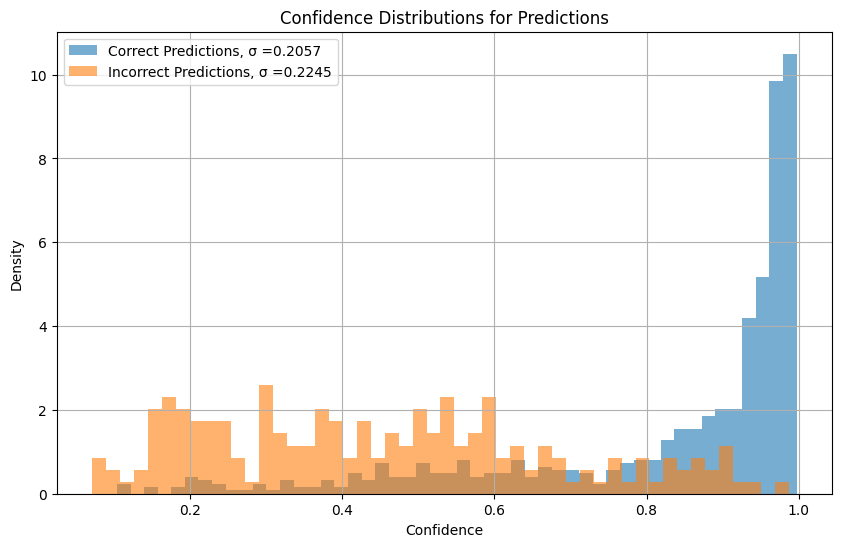

Average confidence for correct predictions: 0.8334664
Average confidence for incorrect predictions: 0.4523443


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def extra_analyse_predictions(model, leftHand, rightHand, labels, class_names=all_labels, batch_size=32):
    correct_confidences = []
    incorrect_confidences = []

    for start in range(0, len(leftHand), batch_size):
        end = min(start + batch_size, len(leftHand))

        lhBatch = [leftHand[i] for i in range(start, end)]
        rhBatch = [rightHand[i] for i in range(start, end)]
        labelBatch = [labels[i] for i in range(start, end)]

        leftPad = Preprocess_Batch(lhBatch)
        rightPad = Preprocess_Batch(rhBatch)

        predictions = model.predict([leftPad, rightPad])
        predicted_labels = np.argmax(predictions, axis=1)

        for idx, true_label in enumerate(labelBatch):
            true_label_idx = class_names.index(true_label)
            predicted_label = predicted_labels[idx]
            true_confidence = predictions[idx, true_label_idx]
            predicted_confidence = predictions[idx, predicted_label]

            if predicted_label == true_label_idx:
                correct_confidences.append(true_confidence)
            else:
                incorrect_confidences.append(predicted_confidence)

    return correct_confidences, incorrect_confidences

def plot_confidence_distributions(correct_confidences, incorrect_confidences):

    mu_correct = np.mean(correct_confidences)
    mu_incorrect = np.mean(incorrect_confidences)
    std_correct = np.std(correct_confidences)
    std_incorrect = np.std(incorrect_confidences)

    plt.figure(figsize=(10,6))
    plt.hist(correct_confidences, bins=50, alpha=0.6, label=f'Correct Predictions, σ ={std_correct:.4f}', density=True)
    plt.hist(incorrect_confidences, bins=50, alpha=0.6, label=f'Incorrect Predictions, σ ={std_incorrect:.4f}', density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distributions for Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
correct_conf, incorrect_conf = extra_analyse_predictions(model, testLeft, testRight, testLabels)
plot_confidence_distributions(correct_conf, incorrect_conf)

# symbol standard deviation: σ
# symbol mean μ

print("Average confidence for correct predictions:" , np.mean(correct_conf))
print("Average confidence for incorrect predictions:", np.mean(incorrect_conf))


In [8]:


def get_all_predictions(model, leftHand, rightHand):
    all_predictions = []
    
    for start in range(0, len(leftHand), 32):
        end = min(start + 32, len(leftHand))
        
        # Prepare batch
        lhBatch = [leftHand[i] for i in range(start, end)]
        rhBatch = [rightHand[i] for i in range(start, end)]
        
        # Preprocess
        leftPad = Preprocess_Batch(lhBatch)
        rightPad = Preprocess_Batch(rhBatch)
        
        # Get predictions
        batch_preds = model.predict([leftPad, rightPad], verbose=0)
        all_predictions.extend(batch_preds)
    
    return np.array(all_predictions)

# Generate predictions for your best model
label_map = {label: i for i, label in enumerate(all_labels)}

testLabels_numerical = [label_map[label] for label in testLabels]

print("Generating predictions...")
y_pred_prob = get_all_predictions(model, testLeft, testRight)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = testLabels_numerical

report = classification_report(
    y_true, 
    y_pred,
    labels=np.arange(len(all_labels)),
    target_names=all_labels,
    digits=3
)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(all_labels)))

perfect_classes = []
for i in range(len(all_labels)):
    # A class has perfect prediction if:
    # 1. All samples of this class were correctly classified (diagonal = row sum)
    # 2. No other class was incorrectly classified as this class (diagonal = column sum)
    if (cm[i, i] == np.sum(cm[i, :]) and cm[i, i] == np.sum(cm[:, i])):
        perfect_classes.append(i)

non_perfect_mask = np.ones(len(all_labels), dtype=bool)
non_perfect_mask[perfect_classes] = False

# Get labels and indices for non-perfect glosses
non_perfect_labels = [all_labels[i] for i in range(len(all_labels)) if non_perfect_mask[i]]
non_perfect_indices = [i for i in range(len(all_labels)) if non_perfect_mask[i]]

# Filter confusion matrix to only include glosses without perfect predictions
cm_filtered = cm[non_perfect_mask][:, non_perfect_mask]






Generating predictions...



--- Generating ROC and PR Curves ---


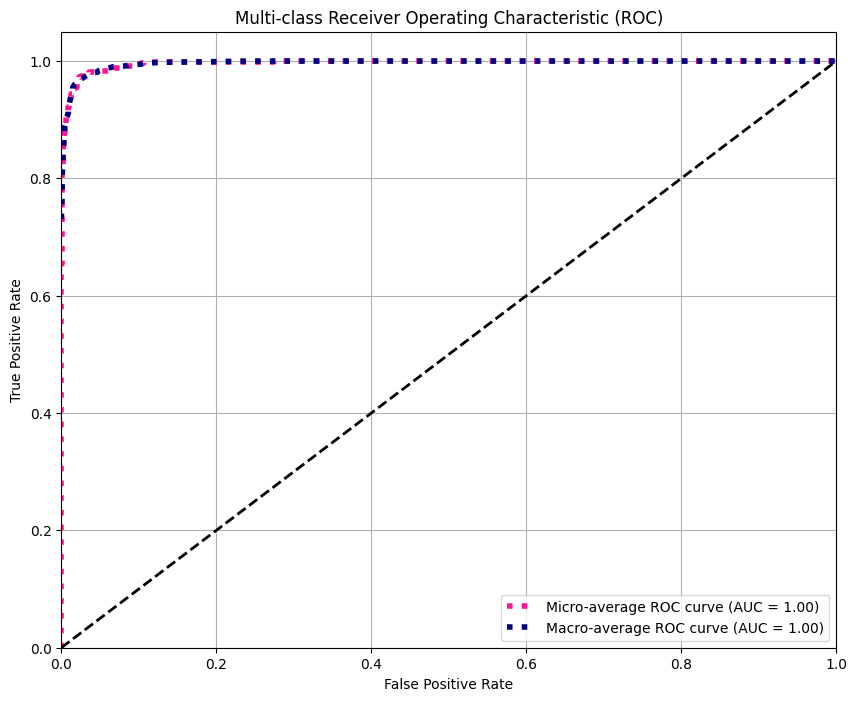

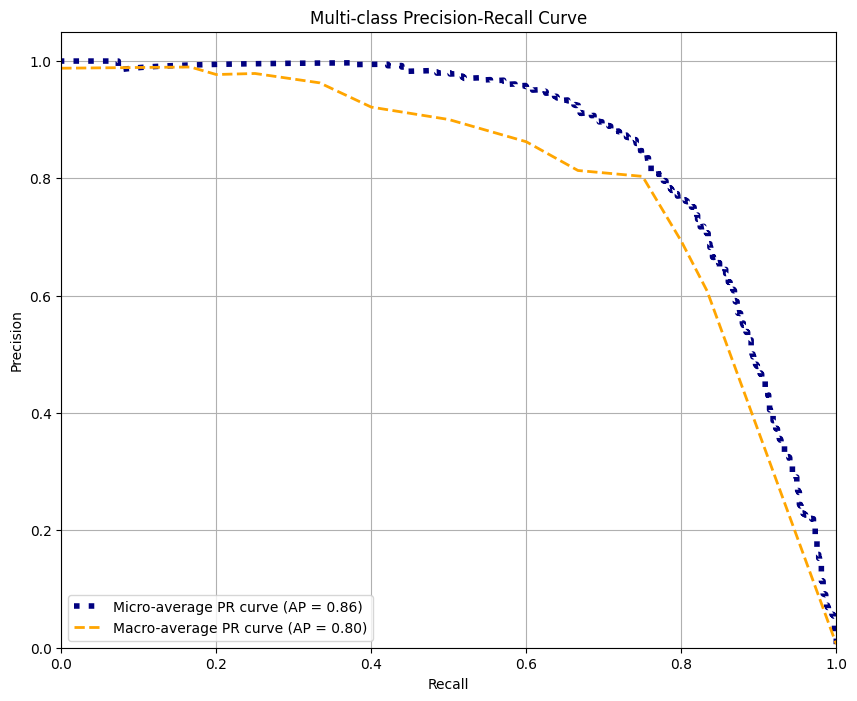

Micro-average ROC AUC: 0.996
Macro-average ROC AUC: 0.997
Micro-average Precision (AP): 0.861
Macro-average Precision (AP): 0.803


In [9]:
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
from matplotlib import pyplot as plt
import numpy as np # Ensure numpy is imported if not done globally

# --- ROC and PR Curve Generation ---

print("\n--- Generating ROC and PR Curves ---")

# Ensure y_true and y_pred_prob are defined from the previous cell
# Ensure nclasses is defined (e.g., nclasses = len(all_labels))
y_true_binarized = label_binarize(y_true, classes=np.arange(nclasses))

# --- ROC Curve (One-vs-Rest and Micro/Macro Averages) ---
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC for each class
for i in range(nclasses):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    # Handle cases where roc_curve might return less than 2 points
    if fpr[i] is not None and tpr[i] is not None and len(fpr[i]) > 1 and len(tpr[i]) > 1:
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        roc_auc[i] = float('nan') # Assign NaN if AUC cannot be calculated

# Calculate micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macro-average ROC
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nclasses) if fpr[i] is not None]))
# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
valid_classes_count_roc = 0
for i in range(nclasses):
     if fpr[i] is not None and tpr[i] is not None and not np.isnan(roc_auc[i]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        valid_classes_count_roc += 1
# Average it and compute AUC
if valid_classes_count_roc > 0:
    mean_tpr /= valid_classes_count_roc
else:
    mean_tpr = np.zeros_like(all_fpr) # Avoid division by zero

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) if valid_classes_count_roc > 0 else float('nan')

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)



plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- Precision-Recall Curve (One-vs-Rest and Micro/Macro Average) ---
precision = dict()
recall = dict()
average_precision = dict()

# Calculate PR for each class
for i in range(nclasses):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    # Handle cases where AP might be undefined (e.g., no positive samples)
    if precision[i] is not None and recall[i] is not None and len(precision[i]) > 0 and len(recall[i]) > 0:
         # Sort by recall for interpolation
        idx = np.argsort(recall[i])
        recall[i] = recall[i][idx]
        precision[i] = precision[i][idx]
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_prob[:, i])
    else:
        average_precision[i] = float('nan') # Assign NaN if AP cannot be calculated
        precision[i] = None
        recall[i] = None


# Calculate micro-average PR
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_binarized.ravel(), y_pred_prob.ravel())
average_precision["micro"] = average_precision_score(y_true_binarized, y_pred_prob, average="micro")

# --- Calculate macro-average PR ---
# Aggregate all recall points (use only valid ones)
all_recall = np.unique(np.concatenate([recall[i] for i in range(nclasses) if recall[i] is not None]))
# Interpolate all PR curves at these points
mean_precision = np.zeros_like(all_recall)
valid_classes_count_pr = 0
for i in range(nclasses):
    if recall[i] is not None and precision[i] is not None and not np.isnan(average_precision[i]):
        # Interpolate precision values onto the common recall axis
        mean_precision += np.interp(all_recall, recall[i], precision[i])
        valid_classes_count_pr += 1

# Average the interpolated precisions
if valid_classes_count_pr > 0:
    mean_precision /= valid_classes_count_pr
else:
    mean_precision = np.zeros_like(all_recall) # Avoid division by zero

recall["macro"] = all_recall
precision["macro"] = mean_precision
# Calculate Macro AP using the interpolated curve
average_precision["macro"] = auc(recall["macro"], precision["macro"]) if valid_classes_count_pr > 0 else float('nan')
# --- End Macro-average PR calculation ---


# Plot PR curves
plt.figure(figsize=(10, 8)) # Adjusted size

# Plot micro-average PR
plt.plot(recall["micro"], precision["micro"],
         label=f'Micro-average PR curve (AP = {average_precision["micro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot macro-average PR
plt.plot(recall["macro"], precision["macro"],
         label=f'Macro-average PR curve (AP = {average_precision["macro"]:0.2f})',
         color='orange', linestyle='--', linewidth=2) # Different color/style


# Optional: Plot all individual class PR curves (faintly, no legend)
# WARNING: Plotting 164 lines will be very cluttered!
# for i in range(nclasses):
#     if recall[i] is not None and precision[i] is not None: # Check if curve exists
#         plt.plot(recall[i], precision[i], lw=1, alpha=0.1) # Faint, thin lines, no label


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc="lower left") # Legend will now show micro and macro
plt.grid(True)
plt.show()

print(f"Micro-average ROC AUC: {roc_auc['micro']:.3f}")
print(f"Macro-average ROC AUC: {roc_auc['macro']:.3f}")
print(f"Micro-average Precision (AP): {average_precision['micro']:.3f}")
print(f"Macro-average Precision (AP): {average_precision['macro']:.3f}")

True: ORANGE, Predicted: METAL, Count: 3
True: WINTER, Predicted: COLD, Count: 2
True: SPRING, Predicted: MORNING, Count: 2
True: HOT, Predicted: BAD, Count: 2
True: SIT, Predicted: CHAIR, Count: 2
True: TENNIS, Predicted: BATHROOM, Count: 2
True: TEA, Predicted: EARTH, Count: 2
True: PICTURE, Predicted: WEATHER, Count: 2
True: SUMMER, Predicted: THINK, Count: 2
True: UP, Predicted: MOON, Count: 2

Confusion between BAD and HOT:
  • HOT predicted as BAD: 2 times
  • BAD predicted as HOT: 2 times
['Correct Label: SOME, Predicted: HAPPY, Output Confidence: 0.3268, Correct Confidence: 0.0889']
['Correct Label: EARTH, Predicted: TRAIN, Output Confidence: 0.1663, Correct Confidence: 0.1569']
['Correct Label: PEN, Predicted: WRITE, Output Confidence: 0.5798, Correct Confidence: 0.1638']
['Correct Label: BEFORE, Predicted: NEXT, Output Confidence: 0.8708, Correct Confidence: 0.0020']
['Correct Label: UP, Predicted: RED, Output Confidence: 0.1801, Correct Confidence: 0.0021']
['Correct Label: 

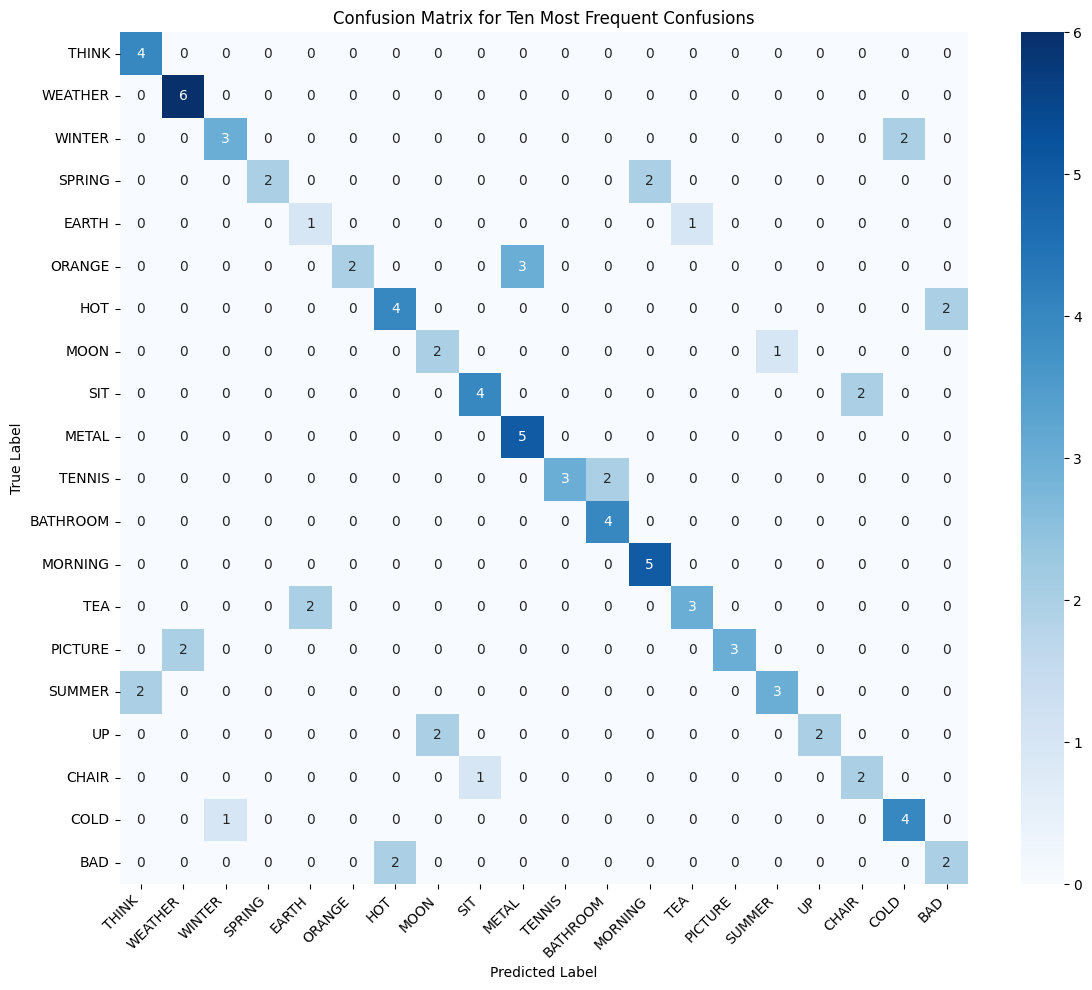

In [10]:
confusions = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusions.append((all_labels[i], all_labels[j], cm[i, j], i, j))  # Store original indices too

# Sort by count and print top 10
confusions.sort(key=lambda x: x[2], reverse=True)
for true_label, pred_label, count, _, _ in confusions[:10]:
    print(f"True: {true_label}, Predicted: {pred_label}, Count: {count}")

# Extract unique classes involved in top 10 confusions
top_classes = set()
for _, _, _, true_idx, pred_idx in confusions[:10]:
    top_classes.add(true_idx)
    top_classes.add(pred_idx)
top_classes = sorted(list(top_classes))  # Get consistent ordering

# Create confusion matrix subset with just these classes
cm_subset = cm[np.ix_(top_classes, top_classes)]
labels_subset = [all_labels[i] for i in top_classes]

# Plotting the proper confusion matrix subset

plt.figure(figsize=(12, 10))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
           xticklabels=labels_subset, yticklabels=labels_subset)
plt.title("Confusion Matrix for Ten Most Frequent Confusions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.show()

# visualize BAD vs HOT specifically
# Get confidence values for BAD and HOT misclassifications


hot_numerical = label_map['HOT']
bad_numerical = label_map['BAD']
badpred = np.where(y_pred == bad_numerical)[0]
hotpred = np.where(y_pred == hot_numerical)[0]

hotconf = y_pred_prob[hotpred, hot_numerical]
badconf = y_pred_prob[badpred, bad_numerical]




if 'BAD' in all_labels and 'HOT' in all_labels:
    bad_idx = all_labels.index('BAD')
    hot_idx = all_labels.index('HOT')
    
    print(f"\nConfusion between BAD and HOT:")
    print(f"  • HOT predicted as BAD: {cm[hot_idx, bad_idx]} times")
    print(f"  • BAD predicted as HOT: {cm[bad_idx, hot_idx]} times")

    

#print(badconf)
#print(hotconf)

# Specifically analyse the confused cases
# True HOT predicted as BAD

#print(y_true)
hotTruesIndex = []
badTruesIndex = []
for i in range(len(y_true)):
    if y_true[i] == hot_numerical:
        hotTruesIndex.append(i)
    
    if y_true[i] == bad_numerical:
        badTruesIndex.append(i)

hotPredsIndex = []
badPredsIndex = []


for index in range(len(y_pred)):
    if y_pred[index] == hot_numerical:
        hotPredsIndex.append(i)
    
    if y_pred[i] == bad_numerical:
        badPredsIndex.append(i)

#print(f"True: {y_true[i]}, Predicted: {y_pred[i]}, Confidence: {y_pred_prob[i, y_pred[i]]:.4f}")


"""
conflicts = []
count = 0
for i in y_true:
    if i == hot_numerical and y_pred[count] == bad_numerical:
        print(f"True: HOT , Predicted: {y_pred[count]}, Confidence: {y_pred_prob[count, y_pred[count]]:.4f}, correct confidence: {y_pred_prob[count, hot_numerical]:.4f}")
    if i == bad_numerical and y_pred[count] == hot_numerical:
        print(f"True: BAD , Predicted: {y_pred[count]}, Confidence: {y_pred_prob[count, y_pred[count]]:.4f}, correct confidence: {y_pred_prob[count, bad_numerical]:.4f}")
    count += 1
"""
#print(hot_numerical)
#print(bad_numerical)

# xth_prediction, largest index =  y_pred_prob[0][26]

def analyse_incorrect_predictions(y_pred_prob, y_true, all_labels):
    incorrect_indices = []
    corresponding_labels = []
    for i in range(len(y_true)):
        if y_pred[i] != y_true[i]:
            incorrect_indices.append(i)
            corresponding_labels.append((y_true[i], y_pred[i]))
    
    correct_labels = [i for i in y_true if i != y_pred[i]]
    incorrect_labels = [i for i in y_pred if i != y_true[i]]
    output_confidences = [y_pred_prob[i, y_pred[i]] for i in incorrect_indices]
    correct_confidences = [y_pred_prob[i, y_true[i]] for i in incorrect_indices]

    #print(len(incorrect_indices), "incorrect predictions")

    outs = []

    for i in range(len(incorrect_indices)):
        #print(f"Correct Label: {all_labels[corresponding_labels[i][0]]}, Predicted: {all_labels[corresponding_labels[i][1]]}, "
         #     f"Output Confidence: {output_confidences[i]:.4f}, Correct Confidence: {correct_confidences[i]:.4f}")
        
        outs.append([corresponding_labels[i][0], f"Correct Label: {all_labels[corresponding_labels[i][0]]}, Predicted: {all_labels[corresponding_labels[i][1]]}, "
              f"Output Confidence: {output_confidences[i]:.4f}, Correct Confidence: {correct_confidences[i]:.4f}"])
    

    from collections import Counter

# count occurrences of each label in outs
    label_counts = Counter(entry[0] for entry in outs)

# sort by that count (most frequent first)
    outs.sort(key=lambda entry: label_counts[entry[0]], reverse=True)    
    frequentMistakes = [ i for i in outs if sum(1 for other in outs if other[0] == i[0]) >1 ]

    #for i in outs:
     #   print(i[1:])
    for mistake in frequentMistakes:
        print(mistake[1:])
    print("Frequent mistakes: ", len(frequentMistakes))

analyse_incorrect_predictions(y_pred_prob, y_true, all_labels)



In [11]:
train = pd.read_csv("trainss_church.csv")
val = pd.read_csv("valss_church.csv")
#test = pd.read_csv("testss_164.csv") alreaady loaded

#merge with primary key = 'Video file'
all = pd.merge(train, val, on='Video file', how='outer')
all = pd.merge(all, test, on='Video file', how='outer')

# Look at balance between train and test for each confused class
confused_classes = ['BAD', 'HOT', 'SIT', 'CHAIR', 'FRUIT', 'BLUE', 'BEFORE', 'EASY', 'NONE', 'SMALL',
                     'MOTHER', 'WATER', 'METAL', 'TRUE', 'WINDOW', 'WHITE', 'LEARN', 'CAKE', 'RESTAURANT', 'COME']

#dont look at church or before otherwise it will break 

#count presence in train, val and test
train_counts = {label: 0 for label in confused_classes}
val_counts = {label: 0 for label in confused_classes}
test_counts = {label: 0 for label in confused_classes}
for label in confused_classes:
    train_counts[label] = len(train[train['Gloss'] == label])
    val_counts[label] = len(val[val['Gloss'] == label])
    test_counts[label] = len(test[test['Gloss'] == label])
# Create a DataFrame for better visualization
counts_df = pd.DataFrame({
    'Class': confused_classes,
    'Train': [train_counts[label] for label in confused_classes],
    'Validation': [val_counts[label] for label in confused_classes],
    'Test': [test_counts[label] for label in confused_classes]
})
# Melt the DataFrame for easier plotting
melted_counts_df = counts_df.melt(id_vars='Class', var_name='Dataset', value_name='Count')
# Plotting
"""plt.figure(figsize=(12, 6))
sns.barplot(data=melted_counts_df, x='Class', y='Count', hue='Dataset')
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()"""

'plt.figure(figsize=(12, 6))\nsns.barplot(data=melted_counts_df, x=\'Class\', y=\'Count\', hue=\'Dataset\')\nplt.title("Class Distribution in Train, Validation, and Test Sets")\nplt.xlabel("Class")\nplt.ylabel("Count")\nplt.xticks(rotation=45)\nplt.legend(title=\'Dataset\')\nplt.tight_layout()\nplt.show()'

In [12]:
# analyse all confusion pairs bidirectionally
def analyse_confusion_pairs(confusions, cm, all_labels):
    analysed_pairs = set()  # Track which pairs we've already analysed
    
    analysed_values = []

    for true_label, pred_label, count, true_idx, pred_idx in confusions:
        pair_key = tuple(sorted([true_label, pred_label]))
        if pair_key in analysed_pairs:
            continue
            
        # Get both directions of confusion
        forward = cm[true_idx, pred_idx]  # true predicted as pred
        reverse = cm[pred_idx, true_idx]  # pred predicted as true
        
        print(f"\nConfusion between {true_label} and {pred_label}:")
        print(f"  • {true_label} predicted as {pred_label}: {forward} times")
        print(f"  • {pred_label} predicted as {true_label}: {reverse} times")
        print(f"  • Total bidirectional confusion: {forward + reverse} times")
        
        analysed_pairs.add(pair_key)
        analysed_values.append({
            'true_label': true_label,
            'pred_label': pred_label,
            'forward': forward,
            'reverse': reverse,
            'total_confusion': forward + reverse
        })
    return analysed_values

# analyse top confused pairs
print("\nBidirectional analysis of top confusions:")
analyse = analyse_confusion_pairs(confusions[:10], cm, all_labels)



Bidirectional analysis of top confusions:

Confusion between ORANGE and METAL:
  • ORANGE predicted as METAL: 3 times
  • METAL predicted as ORANGE: 0 times
  • Total bidirectional confusion: 3 times

Confusion between WINTER and COLD:
  • WINTER predicted as COLD: 2 times
  • COLD predicted as WINTER: 1 times
  • Total bidirectional confusion: 3 times

Confusion between SPRING and MORNING:
  • SPRING predicted as MORNING: 2 times
  • MORNING predicted as SPRING: 0 times
  • Total bidirectional confusion: 2 times

Confusion between HOT and BAD:
  • HOT predicted as BAD: 2 times
  • BAD predicted as HOT: 2 times
  • Total bidirectional confusion: 4 times

Confusion between SIT and CHAIR:
  • SIT predicted as CHAIR: 2 times
  • CHAIR predicted as SIT: 1 times
  • Total bidirectional confusion: 3 times

Confusion between TENNIS and BATHROOM:
  • TENNIS predicted as BATHROOM: 2 times
  • BATHROOM predicted as TENNIS: 0 times
  • Total bidirectional confusion: 2 times

Confusion between TE

In [13]:
#Test worst performing classes vs distribution in dataset

def getLabelDistribution(version='church',labels=all_labels):
    # Load the CSV files
    train_df = pd.read_csv(f"trainss_{version}.csv")
    test_df = pd.read_csv(f"testss_{version}.csv")
    val_df = pd.read_csv(f"valss_{version}.csv")

    # Count occurrences of each label in each set
    train_counts = train_df['Gloss'].value_counts()
    test_counts = test_df['Gloss'].value_counts()
    val_counts = val_df['Gloss'].value_counts()

    lcounts = []

    for label in labels:        
        lcounts.append([label, train_counts.get(label, 0), test_counts.get(label, 0), val_counts.get(label, 0)])


    return lcounts

    # Print the counts
    """print("Train Set Label Distribution:")
    print(train_counts)
    print("\nTest Set Label Distribution:")
    print(test_counts)
    print("\nValidation Set Label Distribution:")
    print(val_counts)
    """
    
num_top_confusions_to_consider = 100 # 

most_confused_labels_set = set()

# Iterate through the top N confusion pairs
for true_label, pred_label, count, _, _ in confusions:
    most_confused_labels_set.add(true_label)
    most_confused_labels_set.add(pred_label)

# Convert the set to a sorted list for consistency
most_confused_labels_list = sorted(list(most_confused_labels_set))

#print the most confused labels and their performance
report_dict = classification_report(
    y_true,
    y_pred,
    labels=np.arange(len(all_labels)),
    target_names=all_labels,
    digits=3,
    output_dict=True  # Get output as dictionary
)

print(f"\n---Performance Metrics for Non Perfect Classes---")

# Print header
print(f"{'Label':<10} {'Precision':<10} {'Recall':<8} {'F1-Score':<10} {'Support':<9}")
print("-" * 49)

ordered_confused = sorted(most_confused_labels_list, key=lambda x: report_dict[x]['f1-score'], reverse=False)
#print(ordered_confused)

dist = getLabelDistribution(labels=most_confused_labels_list)

# Iterate through the confused labels and print their metrics
outlist = []
for label in most_confused_labels_list:
    if label in report_dict: # check
        metrics = report_dict[label]
        outlist.append(f"{label:<12} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1-score']:<10.3f} {metrics['support']:<8}")
    else:
        print(f"{label:<15} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'N/A':<10}")

outlist.sort(key=lambda x: float(x.split()[3]), reverse=False)  # Sort by f1?
for line in outlist:
    print(line)

print("-" * 49)

print(f"Performance for the worst {len(outlist)/164*100:.2f}% performing classes")
print(len(outlist), "out of ", len(all_labels), "classes")






---Performance Metrics for Non Perfect Classes---
Label      Precision  Recall   F1-Score   Support  
-------------------------------------------------
EARTH        0.250      0.200      0.222      5.0     
SOME         0.500      0.200      0.286      5.0     
BAD          0.400      0.400      0.400      5.0     
CHAIR        0.400      0.400      0.400      5.0     
COOK         0.400      0.400      0.400      5.0     
SCHOOL       0.375      0.500      0.429      6.0     
ALL          0.500      0.400      0.444      5.0     
BEFORE       0.667      0.333      0.444      6.0     
MOON         0.500      0.400      0.444      5.0     
PEN          0.667      0.333      0.444      6.0     
UP           0.667      0.333      0.444      6.0     
GIRL         0.667      0.400      0.500      5.0     
SPRING       0.667      0.400      0.500      5.0     
RESTAURANT   0.600      0.500      0.545      6.0     
LONG         1.000      0.400      0.571      5.0     
NEW          0.500    

In [14]:
class_metrics = {label: metrics for label, metrics in report_dict.items() if label in all_labels}
sorted_class_metrics = sorted(class_metrics.items(), key=lambda item: item[1]['f1-score'])

print()



"""
# Print the report
print("\n ------ Sorted Classification Report from Training: -----------")
print(f"{'Label':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")

for(label, metrics) in sorted_class_metrics:
    print(f"{label:<12} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1-score']:<10.3f} {metrics['support']:<8}")
"""

perfect_f1_classes = []
high_f1_classes = []
med_f1_classes = []
bad_f1_classes = []
rest_f1_classes = []

for label, metrics in sorted_class_metrics:
    f1_score = metrics['f1-score']
    if f1_score == 1.0:
        perfect_f1_classes.append((label, metrics))
    elif f1_score > 0.85:
        high_f1_classes.append((label, metrics))
    elif f1_score > 0.66:
        med_f1_classes.append((label, metrics))
    elif f1_score < 0.45:
        bad_f1_classes.append((label, metrics))
    else: # f1_score <= 0.8
        rest_f1_classes.append((label, metrics))

# You can now inspect these lists, for example:
print(f"Number of perfect classes with F1 = 1.0: {len(perfect_f1_classes)}")
print(f"Number of very good performance classes with 0.85 < F1 < 1.0: {len(high_f1_classes)}")
print(f"Number of good performance classes with 0.66 < F1 <= 0.85: {len(med_f1_classes)}")
print(f"Number of poorly performing classes, F1 < 0.45: {len(bad_f1_classes)}")
print(f"Number of classes remaining 0.45 <= F1 <= 0.66: {len(rest_f1_classes)}")

# Example: Print labels of classes with F1 <= 0.8
#print("\nClasses with 0.9 < F1 < 1:")
#for label, metrics in high_f1_classes:
 #    print(f"  {label}: {metrics['f1-score']:.3f}")

print("\nSplits ")
print(f"{len(perfect_f1_classes)/164:.2}% perfect classes with F1 = 1.0")
print(f"{len(high_f1_classes)/164:.2}% of classes very reliable with 0.85 < F1 < 1.0")
print(f"{len(med_f1_classes)/164:.2}% of classes predicted somewhat reliably with 0.66 < F1 <= 0.85")
print(f"{len(rest_f1_classes)/164:.2}% of classes predicted unreliably with 0.45 <= F1 <= 0.66")
print(f"{len(bad_f1_classes)/164:.2}% of classes perform poorly with F1 < 0.45")

print(bad_f1_classes)



Number of perfect classes with F1 = 1.0: 28
Number of very good performance classes with 0.85 < F1 < 1.0: 32
Number of good performance classes with 0.66 < F1 <= 0.85: 76
Number of poorly performing classes, F1 < 0.45: 11
Number of classes remaining 0.45 <= F1 <= 0.66: 17

Splits 
0.17% perfect classes with F1 = 1.0
0.2% of classes very reliable with 0.85 < F1 < 1.0
0.46% of classes predicted somewhat reliably with 0.66 < F1 <= 0.85
0.1% of classes predicted unreliably with 0.45 <= F1 <= 0.66
0.067% of classes perform poorly with F1 < 0.45
[('EARTH', {'precision': 0.25, 'recall': 0.2, 'f1-score': 0.2222222222222222, 'support': 5.0}), ('SOME', {'precision': 0.5, 'recall': 0.2, 'f1-score': 0.2857142857142857, 'support': 5.0}), ('CHAIR', {'precision': 0.4, 'recall': 0.4, 'f1-score': 0.4, 'support': 5.0}), ('COOK', {'precision': 0.4, 'recall': 0.4, 'f1-score': 0.4, 'support': 5.0}), ('BAD', {'precision': 0.4, 'recall': 0.4, 'f1-score': 0.4, 'support': 5.0}), ('SCHOOL', {'precision': 0.375

In [15]:

from collections import OrderedDict

class_entries = ((lbl, m) for lbl,m in report_dict.items() if lbl in all_labels)

sorted_classes = sorted(class_entries, key=lambda x: x[1]['f1-score'])

ordered_report = OrderedDict(sorted_classes)

print(f"{'Gloss':<10}{'Confidence':>6}{'   Recall':>4}{'F1':>4}{'    Support':>8}")
for lbl,metrics in ordered_report.items():
    print(f"{lbl:<12}{metrics['precision']:8.3f}"
          f"{metrics['recall']:8.3f}"
          f"{metrics['f1-score']:8.3f}"
          f"{int(metrics['support']):8d}")



Gloss     Confidence   Recall  F1    Support
EARTH          0.250   0.200   0.222       5
SOME           0.500   0.200   0.286       5
CHAIR          0.400   0.400   0.400       5
COOK           0.400   0.400   0.400       5
BAD            0.400   0.400   0.400       5
SCHOOL         0.375   0.500   0.429       6
MOON           0.500   0.400   0.444       5
UP             0.667   0.333   0.444       6
PEN            0.667   0.333   0.444       6
BEFORE         0.667   0.333   0.444       6
ALL            0.500   0.400   0.444       5
SPRING         0.667   0.400   0.500       5
GIRL           0.667   0.400   0.500       5
RESTAURANT     0.600   0.500   0.545       6
SLOW           0.444   0.800   0.571       5
ORANGE         1.000   0.400   0.571       5
LONG           1.000   0.400   0.571       5
NEW            0.500   0.667   0.571       6
STREET         0.600   0.600   0.600       5
TENNIS         0.600   0.600   0.600       5
TEA            0.600   0.600   0.600       5
SUMMER    

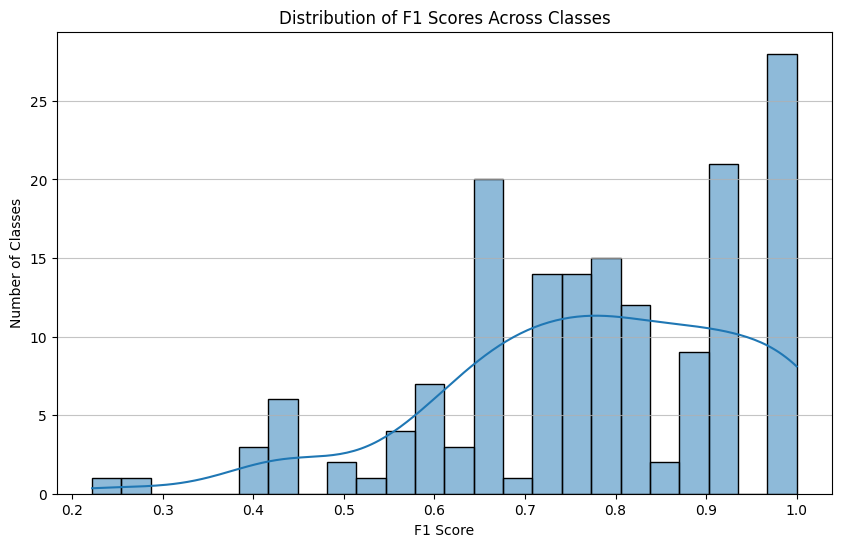

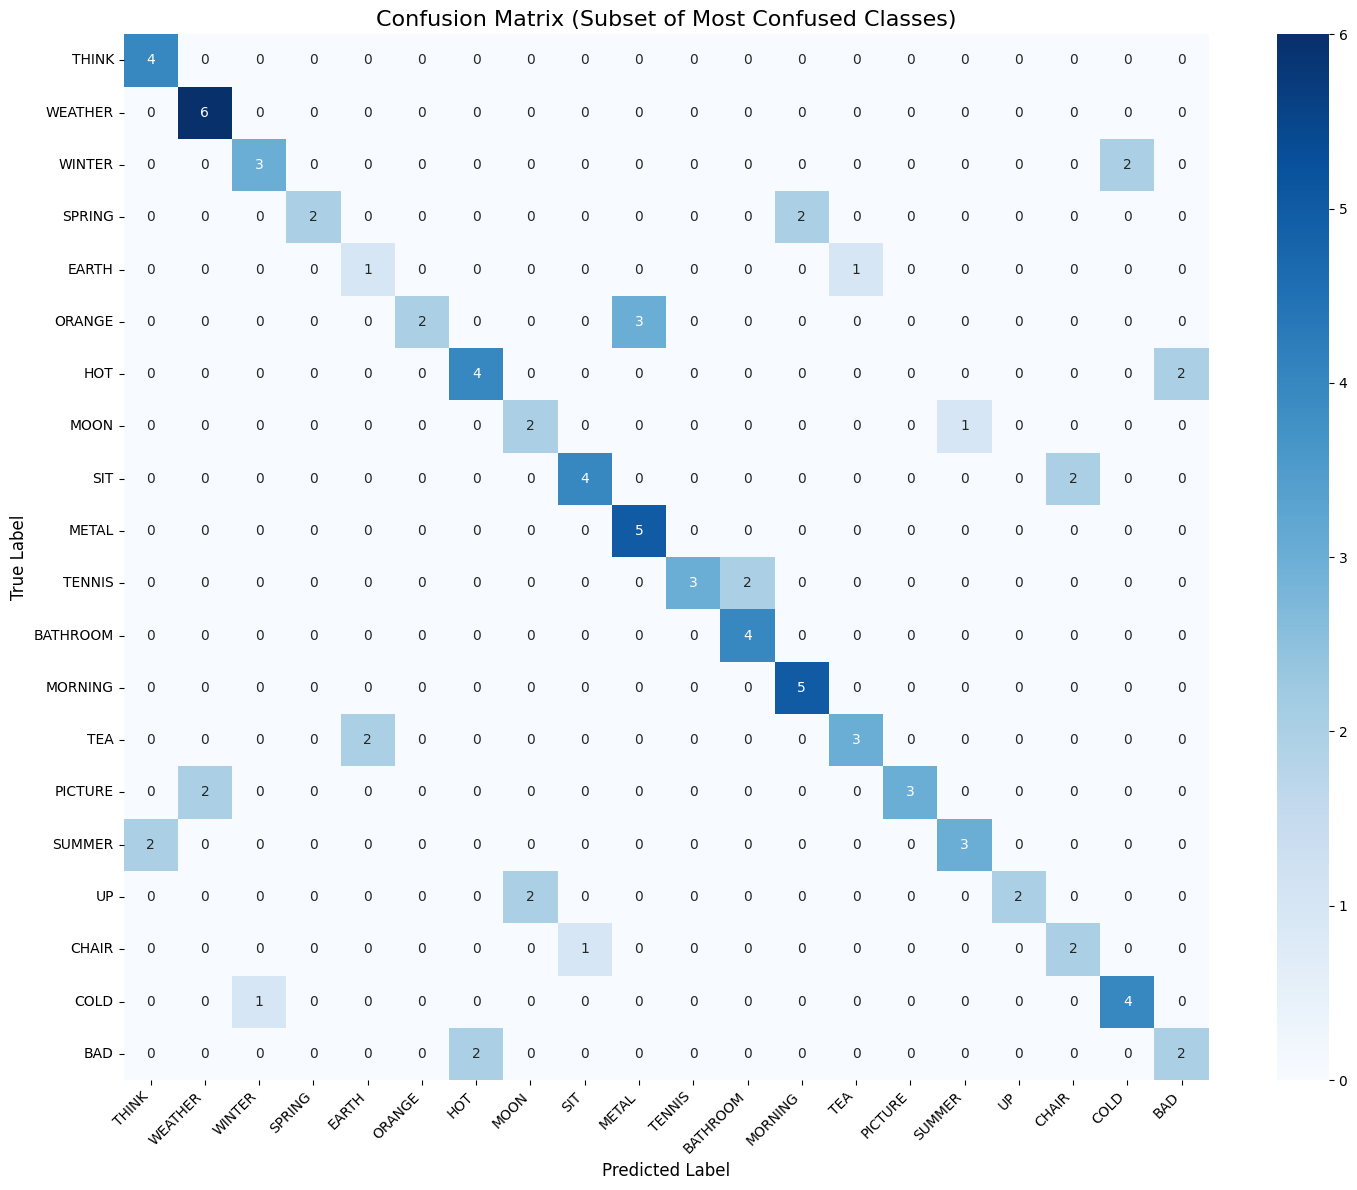

In [16]:
#f1 histogram
f1_scores = [metrics['f1-score'] for label, metrics in report_dict.items() if label in all_labels]


plt.figure(figsize=(10, 6))
sns.histplot(f1_scores, bins=24, kde=True) # Adjust bins as needed
plt.title('Distribution of F1 Scores Across Classes')
plt.xlabel('F1 Score')
plt.ylabel('Number of Classes')
plt.grid(axis='y', alpha=0.75)
plt.show()
"""
plt.figure(figsize=(10, 6))
sns.kdeplot(f1_scores, fill=True)
plt.title('Density Plot of F1 Scores Across Classes')
plt.xlabel('F1 Score')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)
plt.show()
"""

plt.figure(figsize=(15, 12)) # Make it larger
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_subset, yticklabels=labels_subset,
            annot_kws={"size": 10}) # Adjust annotation size if needed
plt.title("Confusion Matrix (Subset of Most Confused Classes)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout
plt.show()
